# Decide on cell clusters to exclude

## Import statements

In [68]:
import scanpy as sc
import scanpy.external as sce
#sc.logging.print_versions()
#sc.logging.print_memory_usage()
#sc.settings.verbosity = 2
import os,sys
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import matplotlib.ticker as mticker

#not all are used, I am just transfering this cell from notebook to notebook

In [69]:
# add the utility function folder to PATH
import sys
sys.path.append(os.path.abspath("utility_functions_190403_12h24/"))

from rz_import_statements import *
import rz_functions as rz
import rz_fig_params # this adjust mpl.rcParams, almost nothing to import, import after scanpy to overwrite rc.Params
import rz_utility_spring as srz

## Load per-cell metadata (obs)

In [70]:

# overwrite obs with the most recent version
filename = 'backups_JZ_2022/scrub_cl_obs_info_51196x27_220125_18h23.npz'
encoding = 'latin1'

with np.load(filename,encoding=encoding, allow_pickle = True) as f:
    obs = pd.DataFrame(**f)


In [71]:
obs.keys()

Index(['library', 'total_counts', 'pct_counts_mito', 'library2', 'sample',
       'patient', 'pT stage', 'seq_date', 'beads', 'operation', 'sex',
       'tumor size, mm', 'age', 'tissue', 'necrosis', 'doublet_score',
       'potential_doublet', 'top3pct_dbtl_score', 'top5pct_dbtl_score',
       'top10pct_dbtl_score', 'closest_JZ_kidney', 'closest_JZ_kidney_hvg',
       'removed_as_RBC', 'louvain_resolution_30.0', 'louvain_resolution_50.0',
       'louvain_resolution_60.0', 'louvain_resolution_80.0'],
      dtype='object')

In [74]:
#for some reason the boolean values True and False are now string, converting
removRBC=[]
for i in obs['removed_as_RBC']:
    if i == 'False':
        removRBC.append(False)
    if i == 'True':
        removRBC.append(True)

In [75]:
sum(removRBC)

47

In [76]:
obs['removed_as_RBC'] = removRBC

## Load cluster labels directly from spring

In [77]:
# load intermediates I saved when preparing the SPRING plot
path1 = '/Users/justina/Documents/mokslai/MAGISTRAS/MAGISTRINIS/data_and_spring/SPRING_dev-master/kidney_spring/' 
project_dir = path1+'kidney_2022/'
plot_name =  'kidney_v0_156_v2000'

# use only cell in the spring plot
cell_ix = np.loadtxt(project_dir+plot_name+'/cell_filter.txt',dtype=int)

In [78]:
# load current color dictionary
cg0 = srz.read_cell_groupings(project_dir+plot_name+'/categorical_coloring_data.json')

# drop the color dictionaries with are part of cell groupings
cg0 = {key:value['label_list'] for key,value in cg0.items()}
cg0.keys()

dict_keys(['age', 'beads', 'closest_JZ_kidney', 'closest_JZ_kidney_hvg', 'library', 'library2', 'louvain_resolution_30.0', 'louvain_resolution_50.0', 'louvain_resolution_60.0', 'louvain_resolution_80.0', 'necrosis', 'operation', 'pT stage', 'patient', 'potential_doublet', 'removed_as_RBC', 'sample', 'seq_date', 'sex', 'tissue', 'top10pct_dbtl_score', 'top3pct_dbtl_score', 'top5pct_dbtl_score', 'tumor size, mm'])

## Note: 
*closest_JZ_kidney* and *closest_JZ_kidney_hvg* categories in obs contain labels for cells that were assigned using a Bayesian classifier exactly as in https://github.com/AllonMKlein/Pfirschke_et_al_2021/blob/master/methods_clean_visual_annot/part3_classify_cell_by_published_profiles.ipynb
The reference expression profiles (regarded as "published" profiles in the notebook) used were constructed by myself in initial analysis when only ~30k cells were sequenced. The labels obtained using this classifier were intended to provide a general, approximate idea about cell types found in the dataset for guidance in the interactive viewer and were not used in any analysis or in actual cell type annotation. 

In [79]:
len(cell_ix)

51196

In [80]:
for key in obs.keys():
    if key not in cg0.keys():
        print (key)

total_counts
pct_counts_mito
doublet_score


## Make a dataframe with per-cell metadata with cluster and doublet info

In [81]:
obs[['doublet_score', 'top10pct_dbtl_score']]

,doublet_score,top10pct_dbtl_score
2,0.026847,False
19,0.045685,False
363,0.102625,False
413,0.241935,True
433,0.061564,False
...,...,...
4865536,0.082664,False
4865584,0.149321,True
4865642,0.104152,False
4865726,0.082664,False


In [82]:
# take doublet info from obs:
o = obs[['top10pct_dbtl_score','doublet_score']].astype(float).copy()
print(o.shape)

(51196, 2)


In [83]:
# choose cluster configuration
# I chose here a detailed one (overclustered)

label = 'louvain_resolution_60.0'

o[label] = obs[label]

o.head(3)

,top10pct_dbtl_score,doublet_score,louvain_resolution_60.0
2,0.0,0.026847,196
19,0.0,0.045685,331
363,0.0,0.102625,610


In [84]:
gb = o.groupby(label)
smr = gb.aggregate({'top10pct_dbtl_score':['count','sum'],
             'doublet_score':['mean']})

smr.columns = smr.columns.droplevel()
smr['dblt_fraction'] = smr['sum']/smr['count']

renamer = {'sum':'nr_cell_in_top10_pct_dblt','mean':'mean_dbt_score'}
smr.columns = [renamer[i] if i in renamer else i for i in smr.columns]

smr.head()

,count,nr_cell_in_top10_pct_dblt,mean_dbt_score,dblt_fraction
louvain_resolution_60.0,,,,
0,269,14.0,0.081462,0.052045
1,247,65.0,0.101440,0.263158
10,179,7.0,0.060220,0.039106
100,115,13.0,0.087260,0.113043
101,114,10.0,0.070404,0.087719


## Plot mean dblt score vs fraction potential dblt

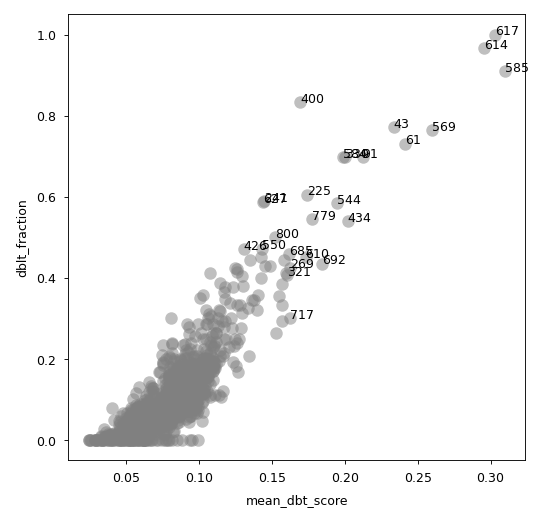

In [85]:
a,fig,gs = rz.startfig(10,10)

lab1 = 'mean_dbt_score'
lab2 = 'dblt_fraction'

x = smr[lab1]
y = smr[lab2]

a.set_xlabel(lab1)
a.set_ylabel(lab2)

# print labels for the top n clusters with highest average dblt score
# and top n with highest fraction
upto=20

thetop = list(x.sort_values(ascending=False)[:upto].index)+\
         list(y.sort_values(ascending=False)[:upto].index)

for i,j,txt in zip(x,y,x.index):
    if txt in thetop:
        a.text(i,j,txt)

a.scatter(x,y,lw=0,c='0.5',alpha=0.5)
#plt.savefig('prec_pca_louv_60_doublets.png')

## Inspect interactively  
In the interactive SPRING explorer (in browser), inspect whether clusters with high scores. convincingly look like doublets

This includes taking into consideration:
- large clusters are not expected to be doublets
- is there unique gene expression in these clusters? Then they are not doublets.
- can you tell from which real populations these clusters where made?

In [88]:
doubcl = [ '617', #near endothelial cells but don't express endothelial markers
           '614', #same situation as with 617
           '585', #scattered near proximal tubule
           '569', #scattered in proximal tubule and macrophage clusters
            '61', #shared expression of T cell, macrophage genes, some cells express proximal tubule markers
           '43', #disguised in endothelial cluster
           '400' #separate clusters in umap
         ]


In [89]:
obs[label].isin(doubcl).sum()

456

In [90]:
# add the cluster configuration used to obs
obs[label] = np.nan
obs.loc[obs.index,[label]] = cg0[label]

In [91]:
# append a colotrack saying "removed_as_doublet"
obs['removed_as_dblt1'] = obs[label].isin(doubcl)
print(obs['removed_as_dblt1'].unique())
obs.head(2)

[False  True]


,library,total_counts,pct_counts_mito,library2,sample,patient,pT stage,seq_date,beads,operation,...,top5pct_dbtl_score,top10pct_dbtl_score,closest_JZ_kidney,closest_JZ_kidney_hvg,removed_as_RBC,louvain_resolution_30.0,louvain_resolution_50.0,louvain_resolution_60.0,louvain_resolution_80.0,removed_as_dblt1
2,N14,449.0,0.668151,T2_1,T2,P2,pT3a,20_11_12,old,Open,...,False,False,TAM 2,TAM 2,False,253,238,196,213,False
19,N14,449.0,4.231626,T2_1,T2,P2,pT3a,20_11_12,old,Open,...,False,False,TAM 2,TAM 2,False,117,239,331,1009,False


In [92]:
# Number of cells that will be removed

for i in obs.columns:
    if i.startswith('removed_as'):
        print(i, sum(obs[i]))

removed_as_RBC 47
removed_as_dblt1 456


## Add colotrack to spring

In [95]:
plot_name

'kidney_v0_156_v2000'

In [96]:
len(cg0.keys())

24

In [97]:
# load current color dictionary
cg_ = srz.read_cell_groupings(project_dir+plot_name+'/categorical_coloring_data.json')

# color dictionary of dictionaries
cdd = {key:value['label_colors'] for key,value in cg_.items()}

cg = obs[[i for i in obs.columns if i.startswith(('removed_as'))]].astype(str).to_dict(orient='list')

# append categorical colortrack
srz.append_cell_groupings(project_dir+plot_name,cg,colordd=cdd)

## Save obs

In [99]:
# save the update obs dataframe
fname = 'backups_JZ_2022/dblt1_obs_info_%dx%d_%s'%(obs.shape[0],obs.shape[1],rz.now())
print(fname)
rz.save_df(obs,fname)

backups_JZ_2022/dblt1_obs_info_51196x28_220126_16h05


/Users/justina/opt/anaconda3/envs/singlecell3/lib/python3.8/site-packages/numpy/lib/format.py:362: UserWarning: metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.
  d['descr'] = dtype_to_descr(array.dtype)
